In [1]:
#Imports

#Data
import pandas as pd
import numpy as np

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#ML

#General
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


#Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
#-------------------------------------------------------------------

data_file='wrang_xyz_data.csv'

financial_data=['total_rev_hi_lim','tot_cur_bal','tot_coll_amt','revol_util','loan_amnt','dti','revol_bal']
loan_data=['purpose','initial_list_status','term']
emp_data=['emp_length','collections_12_mths_ex_med','acc_now_delinq','home_ownership','annual_inc','verification_status','zip_code','addr_state','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','total_acc']
date_data=['earliest_cr_line']
pred_data=['issue_d','default_ind']
out=['initial_list_status','last_pymnt_amnt','total_pymnt','total_rec_int','int_rate','out_prncp','total_rec_late_fee']
features=financial_data+loan_data+emp_data+date_data+out
#out_old=['last_pymnt_d','last_credit_pull_d','initial_list_status','recoveries','collection_recovery_fee','last_pymnt_amnt','total_pymnt','total_rec_int','int_rate','out_prncp',total_rec_late_fee','default_ind']



C:\Users\mmoy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


C:\Users\mmoy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[[11560    88]
 [  403 11183]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11648
           1       0.99      0.97      0.98     11586

    accuracy                           0.98     23234
   macro avg       0.98      0.98      0.98     23234
weighted avg       0.98      0.98      0.98     23234



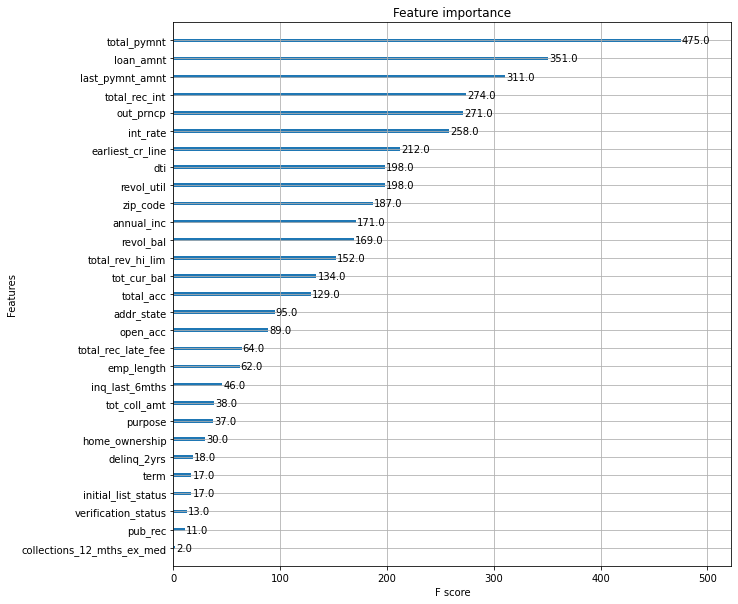

In [2]:
#Default_ind
def get_model_class(data_file='wrang_xyz_data.csv',split='date',model_type='xgb'):

    df = pd.read_csv('data/'+data_file,usecols=features+pred_data)

    if split=='random':
        X=df.drop(['default_ind','issue_d'],axis=1)
        y=df['default_ind']

        undersample = RandomUnderSampler(sampling_strategy='majority')
        X,y = undersample.fit_resample(X, y)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

    else:
        X=df.drop('default_ind',axis=1)
        y=df[['default_ind','issue_d']]

        X_train=X[X['issue_d']<=20150501].drop('issue_d',axis=1)
        X_test=X[X['issue_d']>20150501].drop('issue_d',axis=1)

        y_train=y[y['issue_d']<=20150501]['default_ind']
        y_test=y[y['issue_d']>20150501]['default_ind']

        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train,y_train = undersample.fit_resample(X_train, y_train)
        X_test,y_test = undersample.fit_resample(X_test, y_test)

    if model_type=='xgb':
        model_class = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')
        model_class.fit(X_train,np.ravel(y_train))
        fig, ax = plt.subplots(figsize=(10,10))
        xgb.plot_importance(model_class,importance_type='weight', ax=ax)

    elif model_type=='lg_reg':
        model_class=LogisticRegression(max_iter=10*6)
        model_class.fit(X_train,np.ravel(y_train))

    else: 
        model_class = RandomForestClassifier()
        model_class.fit(X_train,np.ravel(y_train))

    y_class_pred = model_class.predict(X_test)
    print(confusion_matrix(y_test, y_class_pred))
    print(classification_report(y_test, y_class_pred))

    return model_class

model_class=get_model_class(split='random',model_type='xgb')

C:\Users\mmoy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[[4983  636]
 [ 451 5070]]
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      5619
         1.0       0.89      0.92      0.90      5521

    accuracy                           0.90     11140
   macro avg       0.90      0.90      0.90     11140
weighted avg       0.90      0.90      0.90     11140



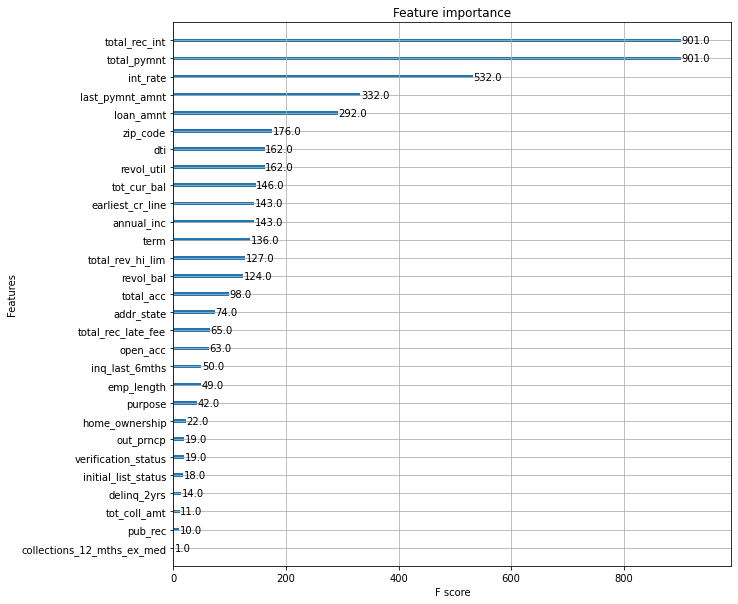

In [4]:
#Recoveries Class
pred_data=['issue_d','default_ind','recoveries','collection_recovery_fee']
def get_model_class(data_file='wrang_xyz_data.csv',model_type='xgb'):

    df = pd.read_csv('data/'+data_file,usecols=features+pred_data)
    df=df[df['default_ind']==1].drop('default_ind',axis=1)
    df['recoveries']=df['recoveries']+df['collection_recovery_fee']
    df['recoveries']=df['recoveries'].where(df['recoveries']==0,1)
    df=df.drop('collection_recovery_fee',axis=1)
    
    X=df.drop(['recoveries','issue_d'],axis=1)
    y=df['recoveries']
    undersample = RandomUnderSampler(sampling_strategy='majority')
    X,y = undersample.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)


    if model_type=='xgb':
        model_class = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')
        model_class.fit(X_train,np.ravel(y_train))
        fig, ax = plt.subplots(figsize=(10,10))
        xgb.plot_importance(model_class,importance_type='weight', ax=ax)

    elif model_type=='lg_reg':
        model_class=LogisticRegression(max_iter=10*6)
        model_class.fit(X_train,np.ravel(y_train))

    else: 
        model_class = RandomForestClassifier()
        model_class.fit(X_train,np.ravel(y_train))

    y_class_pred = model_class.predict(X_test)
    print(confusion_matrix(y_test, y_class_pred))
    print(classification_report(y_test, y_class_pred))

    return model_class

model_class=get_model_class(model_type='xgb')

In [5]:
#Recoveries Reg
pred_data=['issue_d','collection_recovery_fee']
def get_model_reg(data_file='wrang_xyz_data.csv',model_type='xgb',pred_value=['recoveries'],hyper_tune='no'):

    df = pd.read_csv('data/'+data_file,usecols=features+pred_data+pred_value) #default_ind
    df['recoveries']=df['recoveries']+df['collection_recovery_fee']
    df=df[df['recoveries']!=0].drop('collection_recovery_fee',axis=1)
    
    X=df.drop([pred_value[0],'issue_d'],axis=1)
    y=df[pred_value[0]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

   

    if model_type=='xgb':
        if hyper_tune=='random':

            params = { 'max_depth': [3, 5, 6, 10, 15, 20],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
            'n_estimators': [100, 500, 1000]}

            model_reg = xgb.XGBRegressor()

            model_reg = RandomizedSearchCV(estimator=model_reg,
                            param_distributions=params,
                            scoring='r2',
                            n_iter=25,
                            verbose=1)
            model_reg.fit(X_train,np.ravel(y_train))
            print("Best parameters:", model_reg.best_params_)
            print("Lowest RMSE: ", (model_reg.best_score_))

        elif hyper_tune=='grid':
            params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
            model_reg = xgb.XGBRegressor() 
            model_reg = GridSearchCV(estimator=model_reg, 
                            param_grid=params,
                            scoring='neg_mean_squared_error', 
                            verbose=1)
                    
            model_reg.fit(X_train,np.ravel(y_train))
            print("Best parameters:", model_reg.best_params_)
            print("Lowest RMSE: ", (-model_reg.best_score_)**(1/2.0))

        else:
            model_reg = xgb.XGBRegressor() #max_depth=3,learning_rate=0.01,colsample_bytree=0.7,n_estimators=100

            model_reg.fit(X_train,np.ravel(y_train))

    elif model_type=='lin_reg':
        model_reg=LinearRegression()
        model_reg.fit(X_train,np.ravel(y_train))

    elif model_type=='knn':
        model_reg=KNeighborsRegressor(n_neighbors=1)
        model_reg.fit(X_train,np.ravel(y_train))

    elif model_type=='ran_for': 
        model_reg = RandomForestRegressor(n_estimators=200)
        model_reg.fit(X_train,np.ravel(y_train))
    
    else:
        #Neural Networks
        model_reg = MLPRegressor().fit(X_train, y_train)
        model_reg.fit(X_train,y_train)

    y_reg_pred = model_reg.predict(X_test)
    error = np.mean(abs(y_test - y_reg_pred)/y_reg_pred)*100
    print(error)

    #mae = metrics.mean_absolute_error(y_test, y_reg_pred)
    mse = metrics.mean_squared_error(y_test, y_reg_pred)
    rmse = np.sqrt(mse) # or mse**(0.5)  
    r2 = metrics.r2_score(y_test,y_reg_pred)
    #print("MAE:",mae)
    #print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    return model_reg
    
model_reg=get_model_reg(model_type='xgb',pred_value=['recoveries'],hyper_tune='no')

C:\Users\mmoy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


33.254861039225034
RMSE: 1088.121455842609
R-Squared: 0.7346532350145312
